#Develop log

24.04.19
- 학습이 안 되던 문제를 해결. label의 데이터 값이 0, 1로 정수형인데, 이 녀석을 부동소수형으로 변형하여 loss를 계산하던 것이 문제인듯함. label의 값을 LongTensor로 변환하여 loss값을 구하였더니 정상적으로 학습이 됨을 확인함. 
- 다른 문제로 모델의 성능이 상당히 떨어짐을 확인함. validation의 정확도를 기준으로 5epoch에서 정확도가 최대였음. 해당 epoch에서의 train의 정확도는 72% 가량 나옴. 좀 더 정확도를 올릴 수 있는 방법을 찾아보는 것이 좋을듯 함.
- 위와 같이 정확도가 크게 올라가지 못하는 이유로 다음과 같이 추정.
fasttext모델을 학습에 사용하는 코퍼스가 아닌 다른 코퍼스를 사용하여 학습함. 여기서부터 오는 약간의 간극과 더불어 학습에 사용된 코퍼스가 맞춤법이 부정확한 댓글의 특성에 더해져 더욱 큰 성능의 감소를 가져왔다고 추정됨.

24.04.23
- float 이어도 정상적으로 학습이 됨...? 이전 버전의 내용을 확인해봐야 할 필요가 있어보임
- lstm model에서 hidden state가 제대로 된 내용을 리턴하지 않음. 텐서에 0값만 들어있음. -> 이 부분이 문제가 될 수 있다고 생각됨

1. fasttext model 변경 : Not worked
2. dataset label 반환 변경 : Not worked
3. lstm model hidden state 반환 유무 변경 : Not worked
4. optimizer.step() 추가 : Worked but why?

In [1]:
import pandas as pd
import hgtk
from tqdm import tqdm
import fasttext

In [2]:
from torch.utils.data import random_split, DataLoader, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def decompose(forms:list):
    word = ''
    for form in forms:
        try:
            if hgtk.checker.is_hangul(form):
                for s in form:
                    a, b, c = hgtk.letter.decompose(s)
                    if not a:
                        a = '-'
                    if not b:
                        b = '-'
                    if not c:
                        c = '-'
                    word = word + a + b + c
        except TypeError as e:
            print(form)
    return word

In [4]:
fast_model = fasttext.load_model("fasttext_with_NIKL_MP_CSV.bin") # 모델 로드

In [17]:
class CustomDataset(Dataset):
    def __init__(self, csv_dir, num_word, transform = None, target_transform=None):
        self.df = pd.read_csv(csv_dir).sample(frac=1)[:5000]
        self.transform = transform
        self.target_transform = target_transform
        self.num_word = num_word
        self.labels = torch.from_numpy(self.df['label'].values).type(torch.float32)
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        sent = self.df['morphologized_sent'].iloc[i]
        padded_vec = torch.zeros((self.num_word, fast_model.get_dimension()), dtype = torch.float32)
        
        sent2vec = [] 
        for w in sent:
            if w.rstrip():
                sent2vec.append(fast_model.get_word_vector(decompose(w)))
        sent2vec = np.array(sent2vec)
        len_sent = len(sent2vec)
        if len_sent > self.num_word:
            len_sent = self.num_word
        padded_vec[(self.num_word - len_sent):] = torch.from_numpy(sent2vec[:len_sent])
         
        return (padded_vec, self.labels[i])

In [18]:
dataset = CustomDataset('./morphologized_ratings.csv', num_word=32)

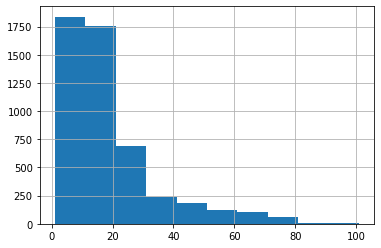

count    5000.000000
mean       18.139200
std        15.326461
min         1.000000
25%         8.000000
50%        14.000000
75%        22.000000
max       101.000000
dtype: float64

In [19]:
sent_len = [len(s.split()) for s in dataset.df['morphologized_sent']]
pd.Series(sent_len).hist()
plt.show()
pd.Series(sent_len).describe()

In [8]:
from collections import defaultdict

dic = defaultdict(int)

for n in sent_len:
    dic[n] += 1

In [9]:
total_cnt = 0
for length, cnt in dic.items():
    total_cnt += cnt
    
    if total_cnt // len(sent_len) * 100 > 90:
        print(length, cnt)

103 1


In [20]:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
batch_size = 32

In [21]:
train_data, valid_data = random_split(dataset, [train_size, valid_size])

In [22]:
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size = batch_size, shuffle=True)

In [23]:
train_sent, train_label = next(iter(train_dataloader))
print(train_sent)
print(train_label)
print(train_sent.size())

tensor([[[ 0.5736, -2.5102,  0.4100,  ..., -2.1188,  2.7128, -2.1250],
         [ 0.5736, -2.5102,  0.4100,  ..., -2.1188,  2.7128, -2.1250],
         [ 0.6993, -0.0494,  1.0716,  ...,  0.7159,  2.3881,  3.3445],
         ...,
         [ 0.3715, -0.0746, -0.4935,  ...,  0.7481,  0.4270,  0.7597],
         [ 0.2678, -1.2395,  2.1219,  ...,  2.3317,  4.0463, -0.2475],
         [-1.9040,  2.4636,  0.6963,  ..., -0.6284,  2.5350, -0.9129]],

        [[ 3.1410, -3.5550, -1.4895,  ...,  1.4553,  0.6382, -1.5765],
         [-2.9753,  0.4030,  0.3323,  ..., -0.4623, -1.6382,  0.1496],
         [ 3.5028, -0.2681, -1.1440,  ...,  0.3329,  0.6166,  0.9899],
         ...,
         [ 3.1898,  0.4495,  0.3376,  ..., -0.7893,  3.3636, -1.4090],
         [-1.0350, -2.5387, -0.6889,  ...,  2.2851, -1.4118,  1.8538],
         [ 3.5028, -0.2681, -1.1440,  ...,  0.3329,  0.6166,  0.9899]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [40]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim, num_word):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=num_layers,batch_first = True)
        
        self.linear = nn.Linear(self.hidden_size, self.output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, _ = self.lstm(x)
        
        drop_out = self.dropout(lstm_out)
        re_drop_out = drop_out.reshape([-1, self.hidden_size])
            
        linear_out = self.linear(re_drop_out)
        
        sig_out = self.sig(linear_out).reshape([batch_size, -1])[:, -1]
        
        return sig_out
        
    def init_hidden(self, batch_size, device):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        
        return (h0, c0)

In [41]:
num_layers = 2
input_size = 100
hidden_size = 128
output_dim = 1

num_word = 32

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [42]:
lstm_model = SentimentLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim, num_word=num_word)

In [43]:
lstm_model.to(device)

SentimentLSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sig): Sigmoid()
)

In [44]:
lr = 0.001
clip = 5
epochs = 5

loss_func = nn.BCELoss()#.to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = lr)

def acc(pred, label):
    correct = torch.eq(pred.round(), label).sum().item()
    return correct

In [45]:
epoch_tr_acc, epoch_tr_loss = [], []
epoch_vl_acc, epoch_vl_loss = [],[]
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    lstm_model.train()
    #h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        #h = tuple([each.data for each in h])
        
        pred = lstm_model(inputs)
        
        loss = loss_func(pred, labels)
        loss.backward()
        train_losses.append(loss.item())
        
        accuracy = acc(pred, labels)

        train_acc += accuracy
        
        nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()

    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tr_acc.append(epoch_train_acc)
    
    val_losses = []
    val_acc = 0.0
    lstm_model.eval()
    #val_h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(valid_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        #val_h = tuple([each.data for each in val_h])
        pred = lstm_model(inputs)

        val_loss = loss_func(pred, labels.float())
        val_losses.append(val_loss.item())
        accuracy = acc(pred, labels)

        val_acc += accuracy
    
    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = val_acc/len(valid_dataloader.dataset)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(25*'==')

100%|██████████| 32/32 [00:02<00:00, 11.76it/s]


Epoch 1
train_loss : 0.6579522981643676 val_loss : 0.6524994056671858
train_accuracy : 60.375 val_accuracy : 60.8


100%|██████████| 32/32 [00:02<00:00, 11.71it/s]


Epoch 2
train_loss : 0.5904372863769531 val_loss : 0.6175963263958693
train_accuracy : 68.525 val_accuracy : 65.2


100%|██████████| 32/32 [00:02<00:00, 11.75it/s]


Epoch 3
train_loss : 0.5254666419029236 val_loss : 0.6048606112599373
train_accuracy : 74.2 val_accuracy : 68.2


100%|██████████| 32/32 [00:02<00:00, 11.83it/s]


Epoch 4
train_loss : 0.4788959572315216 val_loss : 0.6046268371865153
train_accuracy : 77.775 val_accuracy : 70.3


100%|██████████| 32/32 [00:02<00:00, 11.74it/s]

Epoch 5
train_loss : 0.3855954954624176 val_loss : 0.6109053655527532
train_accuracy : 82.875 val_accuracy : 68.89999999999999


In [ ]:
torch.save(lstm_model)

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()